Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

In [1]:
%%capture
!pip install gensim
!python -m spacy download ru_core_news_sm

In [2]:
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import spacy
import tensorflow as tf
import torch

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from string import punctuation
from tqdm.notebook import tqdm

In [3]:
os.environ["KERAS_BACKEND"] = "torch"
print(keras.__version__)

3.5.0


# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:

1) добавьте лемматизацию в предобработку (любым способом)  

2) измените размер окна в большую или меньшую сторону

3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [4]:
class WordIDMapper:
    def __init__(self, corpus):
        self.nlp = spacy.load("ru_core_news_sm", disable=["tagger", "ner"])
        self.nlp.tokenizer = self.tokenize
        vocab, self.lemmatized_sents = self.create_vocab(corpus)
        self.word2id, self.id2word, self.sentences = self.create_indices(
            vocab, self.lemmatized_sents
        )

    def tokenize(self, text):
        tokens = re.sub("#+", " ", text.lower()).split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return spacy.tokens.Doc(self.nlp.vocab, tokens)

    def lemmatize(self, text):
        doc = self.nlp(text)
        lemmata = []
        for sent in doc.sents:
            for token in sent:
                lemmata.append(token.lemma_.lower())
        return lemmata

    def create_vocab(self, corpus):
        unfiltered_vocab = Counter()
        lemmatized_sents = []
        for text in tqdm(corpus, desc="Creating vocab"):
            lemmata = self.lemmatize(text)
            unfiltered_vocab.update(lemmata)
            lemmatized_sents.append(lemmata)
        vocab = set()
        for word in unfiltered_vocab:
            if unfiltered_vocab[word] > 30:
                vocab.add(word)
        return vocab, lemmatized_sents

    def create_indices(self, vocab, sents):
        word2id = {"PAD": 0}
        for word in vocab:
            word2id[word] = len(word2id)
        id2word = {i:word for word, i in word2id.items()}

        sentences = []
        for lemmata in sents:
            if not lemmata:
                continue
            ids = [word2id[lemma] for lemma in lemmata if lemma in word2id]
            sentences.append(ids)

        return word2id, id2word, sentences

In [5]:
wiki = open("wiki_data.txt").read().split("\n")

In [6]:
mapper = WordIDMapper(corpus=wiki)

Creating vocab:   0%|          | 0/20003 [00:00<?, ?it/s]

In [7]:
vocab_size = len(mapper.id2word)

In [8]:
def most_similar(word, mapper, embeddings):
    similar = [
        mapper.id2word[i] for i in
        cosine_distances(
            embeddings[mapper.word2id[word]].reshape(1, -1),
            embeddings
        ).argsort()[0][:10]
    ]
    return similar

## Skip-Gram

In [9]:
# skip gram
def gen_batches_sg(sentences, window=5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = (sent[max(0, i-left_context_length):i] +
                           sent[i+1:i+right_context_length])
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [10]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))

embeddings_target = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                           output_dim=400)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                            output_dim=400)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation="sigmoid")(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [11]:
model.fit(gen_batches_sg(mapper.sentences[:19000], window=7),
          validation_data=gen_batches_sg(mapper.sentences[19000:], window=7),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.7832 - loss: 0.4644 - val_accuracy: 0.7926 - val_loss: 0.5122
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.8235 - loss: 0.4115 - val_accuracy: 0.8276 - val_loss: 0.3916
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.8287 - loss: 0.3992 - val_accuracy: 0.8235 - val_loss: 0.4052
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8335 - loss: 0.3888 - val_accuracy: 0.8301 - val_loss: 0.3885
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8359 - loss: 0.3827 - val_accuracy: 0.8310 - val_loss: 0.3946
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8406 - loss: 0.3711 - val_accuracy: 0.8447 - val_loss: 0.3803
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.8426 - loss: 0.3646 - val_accuracy: 0.8409 - val_loss: 0.3676
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 

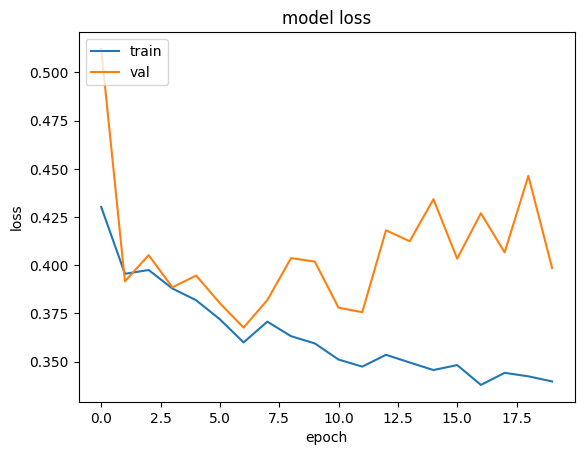

In [12]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [13]:
embeddings = model.layers[2].get_weights()[0]
most_similar("красный", mapper, embeddings)

['красный',
 'жёлтый',
 'чёрный',
 'ель',
 'коричневый',
 'знамя',
 'синий',
 'цвет',
 'розовый',
 'лавровый']

In [14]:
most_similar("улица", mapper, embeddings)

['улица',
 'переулок',
 'у́лица',
 'проспект',
 'бульвар',
 'ул',
 'сквер',
 'нечётный',
 'набережная',
 'микрорайон']

In [15]:
most_similar("должность", mapper, embeddings)

['должность',
 'пост',
 'заместитель',
 'назначить',
 'помощник',
 'судьёй',
 'заведующего',
 'инструктор',
 'отставка',
 'занимать']

## CBOW

In [16]:
def gen_batches_cbow(sentences, window=5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = (sent[max(0, i-left_context_length):i] +
                           sent[i+1:i+right_context_length])

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(
                        X_context,
                        maxlen=window
                    )
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [17]:
#cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(7,))


embeddings_target = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                           output_dim=400)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                            output_dim=400)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(
    lambda x: tf.reduce_sum(x, axis=1), output_shape=(400,))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation="sigmoid")(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [18]:
model.build([(None, 1), (None, 7)])

Больше 5 эпох начинает переобучаться

In [19]:
model.fit(gen_batches_cbow(mapper.sentences[:19000], window=7),
          validation_data=gen_batches_cbow(mapper.sentences[19000:], window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=5)

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8189 - loss: 0.4059 - val_accuracy: 0.8789 - val_loss: 0.2951
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8851 - loss: 0.2806 - val_accuracy: 0.8971 - val_loss: 0.2521
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.9120 - loss: 0.2171 - val_accuracy: 0.8955 - val_loss: 0.2637
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9235 - loss: 0.1918 - val_accuracy: 0.9059 - val_loss: 0.2431
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9344 - loss: 0.1687 - val_accuracy: 0.8841 - val_loss: 0.3125


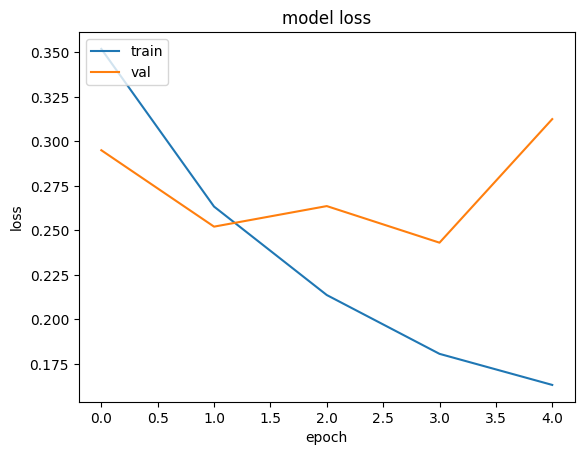

In [20]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [21]:
embeddings = model.layers[2].get_weights()[0]
most_similar("красный", mapper, embeddings)

['красный',
 'жёлтый',
 'белый',
 'чёрный',
 'голубой',
 'зелёный',
 'посередине',
 'синий',
 'серый',
 'розовый']

In [22]:
most_similar("улица", mapper, embeddings)

['улица',
 'проспект',
 'набережная',
 'переулок',
 'бульвар',
 'площадь',
 'ул',
 'сквер',
 'шоссе',
 'мост']

In [23]:
most_similar("должность", mapper, embeddings)

['должность',
 'пост',
 'заместитель',
 'назначить',
 'помощник',
 'советник',
 'назначаться',
 'полномочие',
 'назначение',
 'секретарь']

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [24]:
%%time
w2v_model = gensim.models.Word2Vec(
    mapper.lemmatized_sents,
    vector_size=400,
    min_count=35,
    max_vocab_size=12000,
    window=7,
    epochs=10,
    sg=0,
    hs=0,
    negative=7,
    sample=1e-4,
    ns_exponent=0.5,
    cbow_mean=0
)

CPU times: user 1min 52s, sys: 699 ms, total: 1min 53s
Wall time: 1min 12s


In [25]:
w2v_model.wv.most_similar("красный")

[('жёлтый', 0.9062595367431641),
 ('зелёный', 0.8890085816383362),
 ('цвет', 0.8883638381958008),
 ('белый', 0.8865311145782471),
 ('знамя', 0.8806585073471069),
 ('площадь', 0.8776779770851135),
 ('листоед', 0.8754782676696777),
 ('житомирский', 0.8751746416091919),
 ('в', 0.8749208450317383),
 ('район', 0.8746379613876343)]

In [26]:
w2v_model.wv.most_similar("улица")

[('переулок', 0.9301033616065979),
 ('проспект', 0.9201071262359619),
 ('ул', 0.900672972202301),
 ('олимпийский', 0.8993903398513794),
 ('проезд', 0.8986828327178955),
 ('район', 0.8965555429458618),
 ('игра', 0.8959282636642456),
 ('житомирский', 0.8947595357894897),
 ('хутор', 0.8945783376693726),
 ('танковый', 0.8939675092697144)]

In [27]:
w2v_model.wv.most_similar("должность")

[('пост', 0.9037705659866333),
 ('заместитель', 0.8789244294166565),
 ('назначить', 0.8781725764274597),
 ('помощник', 0.8705217242240906),
 ('код', 0.8666819334030151),
 ('кафедра', 0.8665093183517456),
 ('км²', 0.8655017614364624),
 ('индекс', 0.8621687293052673),
 ('телефонный', 0.8610738515853882),
 ('—', 0.8608745336532593)]

In [28]:
%%time
ft_model = gensim.models.FastText(
    mapper.lemmatized_sents,
    vector_size=400,
    min_count=35,
    max_vocab_size=12000,
    window=7,
    epochs=10,
    sg=0,
    hs=0,
    negative=7,
    sample=1e-4,
    ns_exponent=0.5,
    cbow_mean=0,
    min_n=4,
    max_n=7
)

CPU times: user 13min 32s, sys: 2.65 s, total: 13min 34s
Wall time: 8min 23s


In [29]:
ft_model.wv.most_similar("красный")

[('зелёный', 0.8911484479904175),
 ('чёрный', 0.8910999894142151),
 ('нить', 0.8882411122322083),
 ('опасный', 0.8869094252586365),
 ('тёмный', 0.8840346932411194),
 ('полезный', 0.8833872079849243),
 ('романовский', 0.882720410823822),
 ('старинный', 0.8824141025543213),
 ('мать', 0.8817525506019592),
 ('житомирский', 0.8815016746520996)]

In [30]:
ft_model.wv.most_similar("улица")

[('проезд', 0.9168583750724792),
 ('переулок', 0.9101479053497314),
 ('проспект', 0.9098579287528992),
 ('2001', 0.890173077583313),
 ('игра', 0.8882927298545837),
 ('село', 0.8877872824668884),
 ('дочь', 0.8874737024307251),
 ('овручский', 0.8864575028419495),
 ('2000', 0.8862717151641846),
 ('район', 0.8856457471847534)]

In [31]:
ft_model.wv.most_similar("должность")

[('николаевский', 0.8726380467414856),
 ('назначить', 0.8713619709014893),
 ('александровский', 0.8707780838012695),
 ('брать', 0.8703912496566772),
 ('стать', 0.8688452243804932),
 ('пермский', 0.867543637752533),
 ('олимпийский', 0.8670338988304138),
 ('должный', 0.8669309616088867),
 ('коростенский', 0.8648614883422852),
 ('свердловский', 0.8627920746803284)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор.
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%.

In [32]:
data = pd.read_csv("labeled.csv")
mapper_for_labeled = WordIDMapper(corpus=data["comment"])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Creating vocab:   0%|          | 0/14412 [00:00<?, ?it/s]

In [33]:
labels = np.array(data["toxic"])
texts = mapper_for_labeled.lemmatized_sents

embeddings = np.zeros((len(texts), w2v_model.vector_size))
for i, text in enumerate(texts):
    word_embeddings = [
        w2v_model.wv[word] for word in text if word in w2v_model.wv
    ]
    if word_embeddings:
        embeddings[i] = np.mean(word_embeddings, axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42
)

In [34]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)
print(classification_report(y_test, preds, zero_division=0, digits=4))

              precision    recall  f1-score   support

         0.0     0.7597    0.9321    0.8371      1944
         1.0     0.7349    0.3898    0.5094       939

    accuracy                         0.7555      2883
   macro avg     0.7473    0.6609    0.6733      2883
weighted avg     0.7517    0.7555    0.7304      2883



# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.